In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


from sklearn import model_selection
from sklearn.model_selection import cross_val_score


from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

import pickle
from sklearn.externals import joblib

%load_ext line_profiler
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')


In [2]:
from app import model

In [3]:
url='http://games.espn.com/tournament-challenge-bracket/2017/en/whopickedwhom'
r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, "html5lib")


tbody=soup.find_all('tbody')
rowList=[]
teamList={1: [], 2:[], 3:[], 4:[], 5:[], 6: []}
teamPct={1: [], 2:[], 3:[], 4:[], 5:[], 6: []}
for i,row in enumerate(soup.find_all('tr')):
    if i==0:
        continue
    for irnd,rnd in enumerate(row.find_all('td')):
        teamList[irnd+1].append(rnd.find('span',{'class': 'teamName'}).text)
        teamPct[irnd+1].append(float(rnd.find('span',{'class': 'percentage'}).text.replace('%',''))/100.)


dfpool=pd.DataFrame([[t,p] for t,p in zip(teamList[1],teamPct[1])],columns=['teamName','prob'])

In [4]:
user='gshau'
host='localhost'
dbname='birth_db'

dbname = 'ncaabb'
username = 'gshau' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

years = model.getYears()
year=2017
pointsByRound=[1,2,4,8,16,32]
pointsByRound=[1,2,4,8,12,16]


In [5]:
t=model.Tournament(2017)
t.simulate();
# t.bracketOutcome




pairs = t.getPairings(t.teamList)
teamList=[]
teamNameList=[]
entropyList=[]
probDict={}
for p in pairs:
    
    prob = t.predictGame(p)
    probDict[p[0].name]=prob
    probDict[p[1].name]=1-prob
    
x=np.array([[t,p] for t,p in probDict.items()])

df=pd.DataFrame(x,columns=['teamName','prob'])
df.prob=df.prob.astype('float')
dfprob=df.sort_values(by='prob',ascending=False)
dfprob[dfprob.teamName=='virginia']
t2names=dfprob.teamName.values

In [6]:
t1names=[t.lower().replace(" ","-") for t in dfpool.teamName]

In [7]:
len(set(t2names) & set(t1names))

44

In [8]:
set(t2names)-set(t1names)

{'california-davis',
 'east-tennessee-state',
 'florida-gulf-coast',
 'florida-state',
 'jacksonville-state',
 'kansas-state',
 'miami-fl',
 'middle-tennessee',
 'mount-st-marys',
 'new-mexico-state',
 'north-carolina',
 'north-carolina-wilmington',
 'northern-kentucky',
 'rhode-island',
 'saint-marys-ca',
 'south-dakota-state',
 'southern-california',
 'southern-methodist',
 'virginia',
 'virginia-commonwealth'}

In [9]:
set(t1names)-set(t2names)

nameReplace={}
nameReplace['etsu']='east-tennessee-state'


nameReplace['uc-davis']='california-davis'
nameReplace['fgcu']= 'florida-gulf-coast'
nameReplace['fsu']= 'florida-state'
nameReplace['jacksonville-st']= 'jacksonville-state'
nameReplace['ksu']= 'kansas-state'
nameReplace['miami']= 'miami-fl'
nameReplace['mid-tennessee']= 'middle-tennessee'
nameReplace['msm']= 'mount-st-marys'
nameReplace['new-mexico-st']= 'new-mexico-state'
nameReplace['unc']= 'north-carolina'
nameReplace['unc-wilmington']= 'north-carolina-wilmington'
nameReplace['n-kentucky']= 'northern-kentucky'
nameReplace['uri']= 'rhode-island'
nameReplace["saint-mary's"]= 'saint-marys-ca'
nameReplace['south-dakota-st']= 'south-dakota-state'
nameReplace['usc']= 'southern-california'
nameReplace['smu']= 'southern-methodist'
nameReplace['uva']= 'virginia'
nameReplace['vcu']= 'virginia-commonwealth'

In [10]:
x=[]
for i,name in enumerate(t1names):
    if name in nameReplace.keys():
        x.append(nameReplace[name])
    else:
        x.append(name)
dfpool.teamName = x
# dfpool


In [11]:
df=dfpool.sort_values(by='teamName')
df['probSim']=dfprob.sort_values(by='teamName').prob.values


In [12]:
from sklearn.metrics import r2_score
r2_score(df.prob,df.probSim)

0.84585163388388618

In [13]:
df[df.teamName=='marquette']

,teamName,prob,probSim
28,marquette,0.559,0.153708


In [14]:
x=[]
for tname in df.teamName:
    if tname in t.bracketOutcome[2]:
        x.append(1)
    else:
        x.append(0)
df['actual']=x
# df

In [24]:
model.logit(2*model.logitInv(.75))

0.89999999999999991

In [65]:
model.logit(0.58*model.logitInv(0.85))

0.73225006582616148

Best scale factor:  0.579797979798


Text(0.5,1,'')

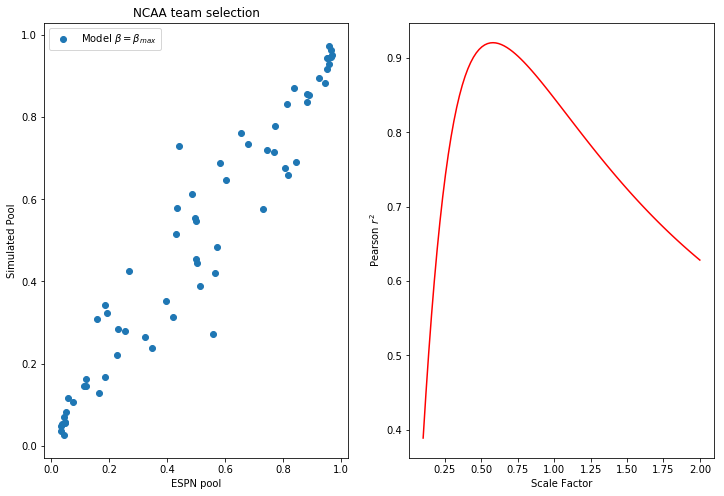

In [62]:
from sklearn.metrics import r2_score

scaleF=np.array([[scaleFactor,r2_score(df.prob,model.logit(scaleFactor*model.logitInv(df.probSim)))] for scaleFactor in np.linspace(0.1,2,100)])
# scaleF=np.array([[scaleFactor,r2_score(model.logit(scaleFactor*model.logitInv(df.prob)),df.probSim)] for scaleFactor in np.linspace(1,5,100)])
indxMax=np.argmax(scaleF[:,1])
scaleBest=scaleF[indxMax,0]
plt.subplot(1,2,1)
# scaleBest=1
plt.scatter(df.prob,model.logit(scaleBest*model.logitInv(df.probSim)),label='Model $\\beta = \\beta_{max}$')
# plt.scatter(model.logit(scaleBest*model.logitInv(df.prob)),df.probSim,label='Model $\\beta = \\beta_{max}$')
# plt.scatter(df.prob,model.logit(0.5*model.logitInv(df.probSim)),label='Model $\\beta = 0.5$')
# plt.scatter(df.prob,model.logit(1*model.logitInv(df.probSim)),label='Model $\\beta = 1$')
plt.xlabel('ESPN pool')
plt.ylabel('Simulated Pool')
plt.title('NCAA team selection')
plt.legend()
plt.subplot(1,2,2)
print('Best scale factor: ',scaleBest)

plt.plot(scaleF[:,0],scaleF[:,1],'r')
plt.xlabel('Scale Factor')
plt.ylabel('Pearson $r^2$');
plt.title('')

Text(0,0.5,'First round predictions')

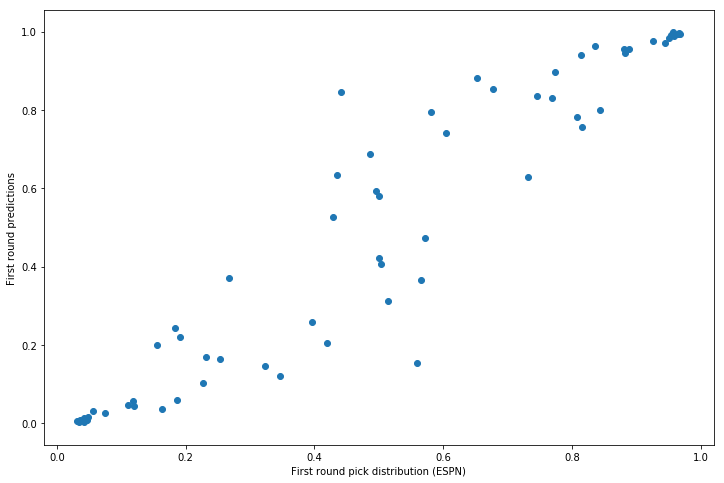

In [25]:
plt.scatter(df.prob,df.probSim)
# plt.scatter(df.prob,df.actual,color='r')
# plt.scatter(df.actual,df.probSim,color='b')
plt.xlabel('First round pick distribution (ESPN)')
plt.ylabel('First round predictions')


In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df.actual.values>.5,df.prob.values>0.5)

array([[26,  6],
       [ 7, 25]])

In [17]:
confusion_matrix(df.actual.values>.5,df.probSim.values>0.5)

array([[29,  3],
       [ 3, 29]])

In [18]:
df[(df.prob>.5) & (df.probSim<0.5)]

,teamName,prob,probSim,actual
28,marquette,0.559,0.153708,0
27,maryland,0.565,0.365377,0
29,michigan-state,0.514,0.312980,1
26,minnesota,0.571,0.472525,0
30,seton-hall,0.504,0.406144,0
